<a href="https://colab.research.google.com/github/ranjith13119/Wafer-Fault-Detection/blob/main/Wafer_Fault_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#http://archive.ics.uci.edu/ml/datasets/SECOM

In [ ]:
# !pip install numpy>=1.20.0
# !pip install pandas>= 1.2.1

# **Original Code**

In [82]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, GridSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics  import roc_auc_score,accuracy_score, classification_report, precision_recall_curve, matthews_corrcoef, roc_curve
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.impute import SimpleImputer, KNNImputer

In [83]:
class Preprocessor:
  def __init__(self, df):
    self.data = df

  def modify_columns(self, data):
    self.data = data
    try:
      self.columns = ["sensor-" + str(col) for col in self.data.columns]
      return self.columns
    except Exception as err:
      raise Exception()  

  def isnull_present(self, data):
    self.null_present = False
    try:
      self.null_counts = data.isna().sum()
      for i in range(len(self.null_counts)):
        if self.null_counts[i] > 0 :
          self.null_present = True
      return self.null_present
    except Exception as err:
      raise Exception()
  
  def impute_missing_values(self, data):
    self.data = data
    try:
      self.imputer = KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
      self.dfData_newArray = self.imputer.fit_transform(self.data)
      self.new_data = pd.DataFrame(data=self.dfData_newArray, columns = self.data.columns)
      return self.new_data
    except Exception as err:
      raise Exception()

  def handle_imbalanced_dataset(self,x,y):
    try:
      self.x_sampled,self.y_sampled = SMOTE(ratio='minority',k_neighbors=10,kind='borderline2',random_state=0).fit_sample(x, y)
      return self.x_sampled,self.y_sampled
    except Exception as err:
      raise Exception()
  
  def corr_features_removel(self, x, threshold):
    try:
      col_corr = set()  # Set of all the names of correlated columns
      corr_matrix = dataset.corr()
      for i in range(len(corr_matrix.columns)):
          for j in range(i):
              if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                  colname = corr_matrix.columns[i]  # getting the name of column
                  col_corr.add(colname)
      return col_corr
    
    except Exception as err:
      raise Exception()


In [84]:
class Model_Finder:
  def __init__(self):
    self.xgb = XGBClassifier(objective='binary:logistic',n_jobs=-1) 
    self.RF = RandomForestClassifier()
    self.smote = SMOTE()
  def get_best_params_for_xgboost(self, train_x, train_y):
    try:
      self.pipeline = Pipeline([('sm', self.smote), ('xgb', self.xgb)])
      self.kf = StratifiedKFold(n_splits = 5)
      self.param_grid_xgboost = { 'sm__sampling_strategy' : [0.10, 0.15, 0.25], 'xgb__learning_rate': [0.1, 0.01, 0.001], 'xgb__max_depth': [3, 5, 10, 20],'xgb__n_estimators': [10, 50, 100, 200] }
      self.grid = RandomizedSearchCV(self.pipeline, param_distributions = self.param_grid_xgboost, scoring = 'roc_auc', cv = self.kf)
      self.grid.fit(train_x, train_y)
      self.learning_rate = self.grid.best_params_['learning_rate']
      self.max_depth = self.grid.best_params_['max_depth']
      self.n_estimators = self.grid.best_params_['n_estimators']
      train_x, train_y = self.get_synthesized_data(self.grid.best_params_["sm__sampling_strategy"])
      self.xgb = XGBClassifier(learning_rate=self.learning_rate, max_depth=self.max_depth,n_estimators= self.n_estimators, n_jobs=-1, random_state = 78)
      self.xgb.fit(train_x, train_y)
      return self.xgb
    except Exception as e:
      raise Exception()
  
  def get_synthesized_data(self,ratio, train_x, train_y):
    self.train_x, self.train_y = SMOTE(sampling_strategy= 0.25,random_state=10, n_jobs = -1).fit_resample(train_x, train_y)
    return self.train_x, self.train_y

  def get_best_params_for_RF(self, train_x, train_y):
    try:
      self.pipeline = Pipeline([('sm', self.smote), ('rf', self.RF)])
      self.kf = StratifiedKFold(n_splits = 5)
      self.params = { 'sm__sampling_strategy' : [0.10, 0.15, 0.25], "rf__n_estimators": [50, 100, 125], "rf__criterion": ['gini', 'entropy'], "rf__max_depth": range(4, 6, 1) , "rf__max_features": ['auto', 'log2'] }
      self.grid = RandomizedSearchCV(self.pipeline, param_distributions = self.params, scoring = 'roc_auc', cv = self.kf)
      self.grid.fit(X_train, y_train)
      self.n_estimators = self.grid.best_params_["rf__n_estimators"]
      self.max_features = self.grid.best_params_["rf__max_features"]
      self.criterion = self.grid.best_params_["rf__criterion"]
      self.max_depth = self.grid.best_params_["rf__max_depth"]
      train_x, train_y = self.get_synthesized_data(self.grid.best_params_["sm__sampling_strategy"])
      self.rf_classifier = RandomForestClassifier(n_estimators = self.n_estimators, max_features= self.max_features, max_depth = self.max_depth,
                                                  criterion = self.criterion, random_state = 78, class_weight = "balanced")
      self.rf_classifier.fit(train_x, train_y)
      return self.rf_classifier
    except Exception as e:
      raise Exception

  def get_best_model(self, train_x, test_x, train_y, test_y):
    try:
      self.xgboost= self.get_best_params_for_xgboost(train_x,train_y)
      self.prediction_xgboost = self.xgboost.predict(test_x)
      if len(test_y.unique()) == 1: #if there is only one label in y, then roc_auc_score returns error. We will use accuracy in that case
          self.xgboost_score = accuracy_score(test_y, self.prediction_xgboost)
      else:
          self.xgboost_score = roc_auc_score(test_y, self.prediction_xgboost) # AUC for XGBoost 
      
      self.RF = self.get_best_params_for_RF(train_x,train_y)
      self.prediction_RF=self.svm.predict(test_x)

      if len(test_y.unique()) == 1: 
          self.rf_score = accuracy_score(test_y,self.prediction_RF)
      else:
          self.rf_score = roc_auc_score(test_y, self.prediction_RF) # AUC for Random Forest

      print("Prediction completed")

      #comparing the two models
      if self.xgboost_score > self.rf_score:
          return 'XGBoost', self.xgboost, self.xgboost_score
      else:
        return 'Random Forest', self.RF, self.rf_score
    except Exception as e:
      raise Exception()

In [92]:
class TrainModel:
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels
  def trainingModel(self):
    try:
      preprocessor = Preprocessor(self.data)
      self.data.columns = preprocessor.modify_columns(self.data)
      is_null_present = preprocessor.isnull_present(self.data)
      if (is_null_present):
        self.data = preprocessor.impute_missing_values(self.data)
      X,Y = self.data, self.labels.loc[:,0]
      self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, Y, test_size = 1/3 , random_state = 0)
      # corr = corr_features_removel(X_train, 0.9)
      # self.X_train.drop(corr, inplace = True, axis = 1)
      # self.X_test.drop(corr, inplace = True, axis = 1)
      model_finder = Model_Finder() 
      best_model_name, best_model, best_score = model_finder.get_best_model(self.X_train, self.X_test, self.y_train, self.y_test) 
      print("best model is {} ".format(best_model_name))
      filename = '/content/drive/MyDrive/Classification/Wafer Fault Classification/best_model_{}.sav'.format(best_model_name)
      pickle.dump(best_model, open(filename, 'wb'))    
      loaded_model = pickle.load(open(filename, 'rb'))
      self.y_predict = loaded_model.predict(self.X_test)
      print(confusion_matrix(self.y_test,self.y_predict))
      print(accuracy_score(self.y_test,self.y_predict))
      print(classification_report(self.y_test,self.y_predict))
    except Exception as e:
      raise Exception() 


In [ ]:
try:
  dfData = pd.read_csv('/content/drive/MyDrive/Classification/Wafer Fault Classification/secom.data.txt',delimiter=' ',header=None)
  dfLabels = pd.read_csv('/content/drive/MyDrive/Classification/Wafer Fault Classification/secom_labels.data.txt',delimiter=' ',header=None)
  trainModelObj = TrainModel(dfData, dfLabels)
  trainModelObj.trainingModel()
except Exception as e:
  raise Exception()

# **Test Code**

In [48]:
dfData = pd.read_csv('/content/drive/MyDrive/Classification/Wafer Fault Classification/secom.data.txt',delimiter=' ',header=None)
dfLabels = pd.read_csv('/content/drive/MyDrive/Classification/Wafer Fault Classification/secom_labels.data.txt',delimiter=' ',header=None)

In [50]:
# using KNN imputer to fill the null value

from sklearn.impute import SimpleImputer, KNNImputer
def impute_missingValue(data):
  imputer = KNNImputer(n_neighbors=3, weights='uniform',missing_values=np.nan)
  dfData_newArray = imputer.fit_transform(data)
  new_data = pd.DataFrame(data=dfData_newArray, columns = data.columns)
  return new_data

In [51]:
dfData = impute_missingValue(dfData)

In [54]:
# remove the columns with Zero Standard Deviation

columns = dfData.columns
columns_drop = []
for x in columns:
  if dfData[x].std() == 0 :
    columns_drop.append(x)

In [55]:
dfData.drop(columns_drop, axis = 1, inplace = True)

In [57]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
X = dfData
y = dfLabels.loc[:,0]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 / 3, random_state=355)

sm = SMOTE()
rf = RandomForestClassifier()

pipeline = Pipeline([('sm', sm), ('rf', rf)])

kf = StratifiedKFold(n_splits = 5)

params = {
    'sm__sampling_strategy' : [0.10, 0.15, 0.25],
    "rf__n_estimators": [50, 100, 125], 
    "rf__criterion": ['gini', 'entropy'], 
    "rf__max_depth": range(4, 6, 1) , 
    "rf__max_features": ['auto', 'log2']
}

grid = RandomizedSearchCV(pipeline, param_distributions = params, scoring = 'roc_auc', cv = kf)

grid.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('sm', SMOTE()),
                                             ('rf', RandomForestClassifier())]),
                   param_distributions={'rf__criterion': ['gini', 'entropy'],
                                        'rf__max_depth': range(4, 6),
                                        'rf__max_features': ['auto', 'log2'],
                                        'rf__n_estimators': [50, 100, 125],
                                        'sm__sampling_strategy': [0.1, 0.15,
                                                                  0.25]},
                   scoring='roc_auc')

In [58]:
grid.best_params_

{'rf__criterion': 'entropy',
 'rf__max_depth': 4,
 'rf__max_features': 'auto',
 'rf__n_estimators': 50,
 'sm__sampling_strategy': 0.25}

In [59]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 / 3, random_state=355)

In [60]:
from imblearn.over_sampling import SMOTE 
X_train, y_train = SMOTE(sampling_strategy= grid.best_params_['sm__sampling_strategy'],random_state=10, n_jobs = -1).fit_resample(X_train, y_train)

In [76]:
clf = RandomForestClassifier(n_estimators = 50, max_features= 'auto', max_depth = 4,
                                                  criterion = 'entropy', random_state = 78, class_weight = "balanced")

In [77]:
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=4, n_estimators=50, random_state=78)

In [78]:
prediction = clf.predict(X_test)
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test,prediction)
print('Accuracy: %.3f'%acc)
print(classification_report(y_test,prediction)) 
print(roc_auc_score(y_test,prediction))

Accuracy: 0.866
              precision    recall  f1-score   support

          -1       0.94      0.91      0.93       487
           1       0.19      0.28      0.22        36

    accuracy                           0.87       523
   macro avg       0.56      0.59      0.57       523
weighted avg       0.89      0.87      0.88       523

0.5937143509012092


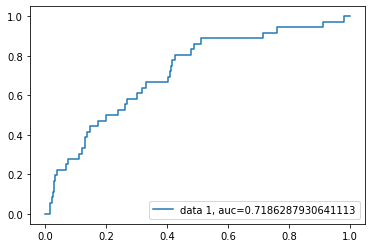

In [299]:
y_pred_proba = clf.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()